In [1]:
import pandas as pd
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.corpus import stopwords
import re

from sklearn.feature_extraction.text import TfidfVectorizer

stopset = set(stopwords.words('english'))

In [43]:
def parse(path):
    f = open(path, 'rb')
    for l in f:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('All_Beauty.json')
meta_df = getDF('meta_All_Beauty.json')
#df = getDF('Luxury_Beauty.json')
#meta_df = getDF('meta_Luxury_Beauty.json')

In [44]:
print(len(df))
df.head()

371345


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1.0,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN
1,4.0,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800,NaN,NaN,NaN
2,4.0,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all a...",Worth the Read,1407628800,NaN,NaN,NaN
3,5.0,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,TamB,I am already a baseball fan and knew a bit abo...,Good Read,1362960000,NaN,NaN,NaN
4,5.0,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,shoecanary,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",1324771200,5,NaN,NaN


In [12]:
meta_df.head()

,title,image,brand,rank,main_cat,asin,description,also_view,also_buy,price,similar_item,details,feature,tech1,date
0,Workout Headphones by Arena Essentials,[https://images-na.ssl-images-amazon.com/image...,HarperCollins,"3,235,148inBeautyamp;PersonalCare(",All Beauty,0061073717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Black Diamond,NaN,Swedish Beauty,"1,462,563inBeautyamp;PersonalCare(",All Beauty,0143026860,[This is the NEW PURPLE BOTTLE that just came ...,[B000LXTNMW],NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"12 Pc BLUE HEAVEN KAJAL""HERBAL kajal With VITA...",NaN,BLUE HEAVE,"100,425inBeautyPersonalCare(",All Beauty,014789302X,"[A brand-new, unused, unopened, undamaged item...","[B00OWT3W28, B0796RMSV8, B010E1X15K, B010FQJWW...","[B00OWT3W28, B010E1X15K, B0796RMSV8, B07HPBWSW...",$6.45,NaN,NaN,NaN,NaN,NaN
3,The Inheritance,NaN,Sunatoria,"476,831inBeautyPersonalCare(",All Beauty,0571348351,[You have to wonder why there isn't a word in ...,"[0571352367, 0573697094, 1635571766, 155936597...","[1848426380, B07JVF7M3C, 1644450003, 163557176...",NaN,NaN,NaN,NaN,NaN,NaN
4,The Listening Cards,[https://images-na.ssl-images-amazon.com/image...,Listening Planet,"2,967,592inBeautyamp;PersonalCare(",All Beauty,0692508988,[The Listening Cards are an eloquent primer in...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
print('item: {}'.format(len(set(df['asin']))))
print('user: {}'.format(len(set(df['reviewerID']))))
print('brand: {}'.format(len(set(meta_df['brand']))))

item: 32586
user: 324038
brand: 7895


### 作るtriplet
- user ->(buy) item
- user ->(mention) feature
- item ->(described_by) feature
- item ->(belong to) brand
- item ->(also_view) item
- item ->(also_buy) item


考えること
- ratingの情報はどうするか。3以上にリンクを残すなど
- priceの情報はどうするか。ある閾値以上にリンクを張るなど.

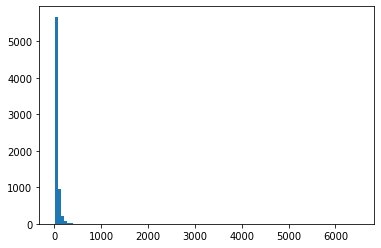

,count,mean,std,min,25%,50%,75%,max
0,6958.0,46.10283,92.443779,1.0,19.5,29.99,52.9975,6500.0


In [17]:
price = []
for p in np.array(meta_df['price']):
    if type(p) != str:
        continue
    try:
        price.append(float(p[1:].replace(',', '')))
    except:
        print(p)
plt.hist(price, bins=100)
plt.show()
pd.DataFrame(pd.Series(price).describe()).transpose()

4分位数等をつかって、priceを四つにランク付けするか?
- priceのノードに辺が集まりすぎる

特別に高価なアイテムだけリンクをつけるなど。2\sigma以上など


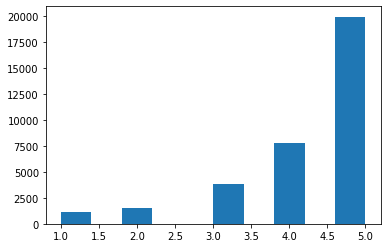

In [301]:
plt.hist(df['overall'])
plt.show()

ratingが1, 2のリンクは消すなど

## 辞書を作る

In [ ]:
user2id = {}
item2id = {}
brand2id = {}
for u in df['reviewerID']:
    if u not in user2id:
        user2id[u] = len(user2id)
        
for item in df['asin']:
    if item not in item2id:
        item2id[item] = len(item2id)
        
for b in meta_df['brand']:
    if b not in brand2id:
        brand2id[b] = len(brand2id)
        
print(user2id)
print(item2id)
print(brand2id)

## reviewとdescriptionからfeatureを取り出す

In [14]:
# 半角記号削除
def del_kigou(text):
    text = re.sub(r'[0-9!-/:-@¥[-`{-~]*', "", text)
    return text

In [7]:
stemmed = []

lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()

rev = []

for r in list(df['reviewText']):
    if type(r) != str:
        continue
    rev.append(r)
    
for r in list(meta_df['description']):
    if type(r) != list:
        continue
    rev.append(r[0])


In [15]:
# 名詞のみ
corpus = []
nouns_tag = ['NN', 'NNS', 'NNP', 'NNPS']

for text in rev[0:1000]:
    text = del_kigou(text)
    tagged = nltk.pos_tag(text.lower().split())
    
    nouns = ''
    for w, tag in tagged:
        if w in stopset:
            continue
        if tag in nouns_tag:
            # 語幹化
            w = lemmatizer.lemmatize(w)
            #w = stemmer.stem(w)
            nouns += ' ' + w
            
    corpus.append(nouns)

In [10]:
# 単語の頻度を返す
def get_word_freq(corpus):
    word_freq = {}
    for text in corpus:
        for w in text.split(' '):
            if w not in word_freq:
                word_freq[w] = 1
            else:
                word_freq[w] += 1
    return word_freq

In [11]:
word_freq = get_word_freq(corpus)
tfidf_trans = TfidfVectorizer()
tfidf = tfidf_trans.fit_transform(corpus)
feat_words = tfidf_trans.get_feature_names()

In [13]:
len(feat_words)

2295

あるrecordにおいて(dfの行)、tfidfがある閾値以上かつ単語の頻度がある閾値以下のときに、uesrがその単語にmentionしているとする

## Tripletを作る

In [45]:
# user ->(buy) item
user_item_df = pd.concat([df['reviewerID'], df['asin']], axis=1)
print(len(user_item_df))

371345


In [46]:
# item ->(belong_to) brand
item_set = set(df['asin'])
item_brand_df = pd.concat([meta_df['asin'], meta_df['brand']], axis=1)

del_idx = []
for i in range(len(meta_df)):
    if meta_df['asin'][i] not in item_set:
        del_idx.append(i)

item_brand_df.drop(del_idx)
brand = item_brand_df['brand'].values
count = 0
for b in brand:
    if type(b) != str:
        count += 1
print(len(brand) - count)

17302


In [50]:
# item ->(also_view) item
item_view_item_df = pd.concat([meta_df['asin'], meta_df['also_view']], axis=1)

del_idx = []
for i in range(len(meta_df)):
    if meta_df['asin'][i] not in item_set:
        del_idx.append(i)

item_view_item_df.drop(del_idx)

also_view = item_view_item_df['also_view'].values
count = 0
for a in also_view:
    if type(a) != list:
        count += 1
print(len(also_view) - count)

8155


In [52]:
# item ->(also_buy) item
item_buy_item_df = pd.concat([meta_df['asin'], meta_df['also_buy']], axis=1)

del_idx = []
for i in range(len(meta_df)):
    if meta_df['asin'][i] not in item_set:
        del_idx.append(i)

item_buy_item_df.drop(del_idx)

also_buy = item_buy_item_df['also_buy'].values
count = 0
for a in also_buy:
    if type(a) != list:
        count += 1
print(len(also_buy) - count)


6613


In [53]:
# 保存
user_item_df.to_csv('user_item.csv', index=False)
item_brand_df.to_csv('item_brand.csv', index=False)
item_view_item_df.to_csv('item_view_item.csv', index=False)
item_buy_item_df.to_csv('item_buy_item.csv', index=False)

In [272]:
# user ->(mention) item
thre_thidf = 0.2
thre_freq = 100

In [16]:
print(tfidf)

  (0, 1854)	0.4880324802554905
  (0, 951)	0.3403177296309513
  (0, 852)	0.4057569517648583
  (0, 952)	0.6938079252999344
  (1, 184)	0.3118891696557429
  (1, 1759)	0.36712462784348177
  (1, 2215)	0.2921634918425743
  (1, 2082)	0.30234218626161524
  (1, 1944)	0.45331722877652486
  (1, 1856)	0.22138657314327106
  (1, 1216)	0.4707881075667177
  (1, 951)	0.3391524480571183
  (2, 1884)	0.6126503505988063
  (2, 521)	0.31712001102728626
  (2, 2215)	0.2863851208295534
  (2, 951)	0.6648894713293749
  (3, 2057)	1.0
  (4, 1884)	0.673151603612957
  (4, 1759)	0.39540141722074795
  (4, 1216)	0.5070492983159838
  (4, 951)	0.3652747553423271
  (5, 1870)	0.6661499467397057
  (5, 930)	0.5586866273467649
  (5, 633)	0.44766592214864476
  (5, 1612)	0.20906631251683702
  :	:
  (997, 1856)	0.10625794076311504
  (998, 1930)	0.28654888444704474
  (998, 1298)	0.3134416327400452
  (998, 1326)	0.2532391868676179
  (998, 2260)	0.3134416327400452
  (998, 1327)	0.3900787061429222
  (998, 1236)	0.13991631657681775
  (

In [282]:
i = 0
for w in tfidf:
    print(w)
    if i > 1: break
    i += 1


  (0, 5327)	0.49007565633075695
  (0, 550)	0.34269184164761174
  (0, 2286)	0.49007565633075695
  (0, 1489)	0.2595233622077852
  (0, 47)	0.29700178176009323
  (0, 366)	0.44289293609535224
  (0, 2471)	0.2247163035221493
  (0, 2031)	0.5387974197002788
  (0, 260)	0.6382670787324727
  (0, 550)	0.5498294978724196


In [286]:
print(tfidf[1])

  (0, 5327)	0.49007565633075695
  (0, 550)	0.34269184164761174
  (0, 2286)	0.49007565633075695
  (0, 1489)	0.2595233622077852
  (0, 47)	0.29700178176009323
  (0, 366)	0.44289293609535224
  (0, 2471)	0.2247163035221493
